In [1]:
#!hide
from PIL import Image
import cv2
import os
def show(image):
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR → RGB로 채널 순서 변경
    return Image.fromarray(rgb) # 객체 변환: 넘파이 배열 → PIL 형식으로
os.chdir('C:/Users/eupho/Dropbox/@강의/_강의슬라이드/이미지/ipynb/data')

In [2]:
import cv2
img1 = cv2.imread('taekwonv1.jpg') # 비교할 이미지 로드
img2 = cv2.imread('figures2.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) # 특징점 검출을 위해 흑백으로
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

# ORB(Oriented FAST and Rotated BRIEF) 특징점 검출기
detector = cv2.ORB_create()  # 검출기 생성
kp1, desc1 = detector.detectAndCompute(gray1, None)  # 각 이미지의 키포인트(kp)와
kp2, desc2 = detector.detectAndCompute(gray2, None)  # 디스크립터(desc)를 추출


In [3]:
# BFMatcher(Brute-Force Matcher)를 생성
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)

# 매칭된 결과를 거리의 오름차순으로 정렬(가까울 수록 좋은 매칭)
matches = sorted(matches, key=lambda x:x.distance)


In [4]:
from PIL import Image
def show(image):
    dst = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(dst)

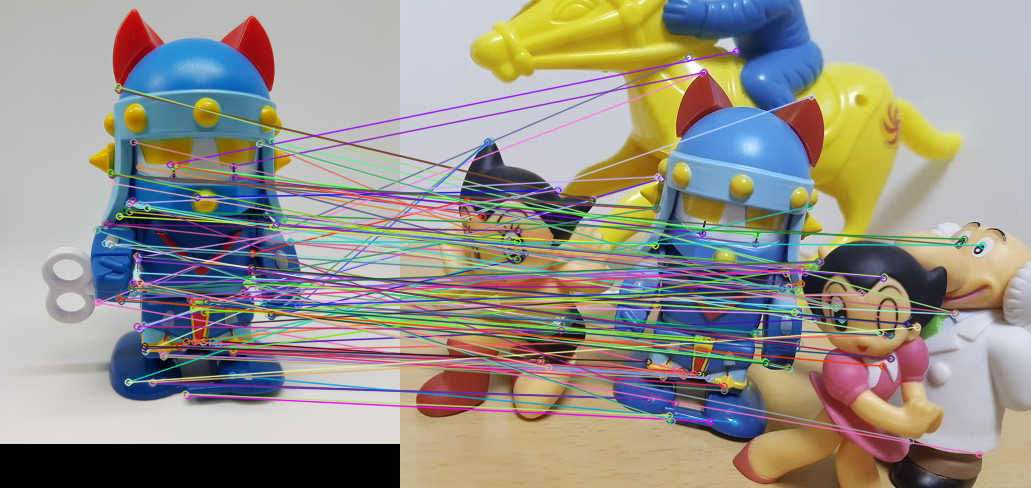

In [5]:
res1 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
show(res1)

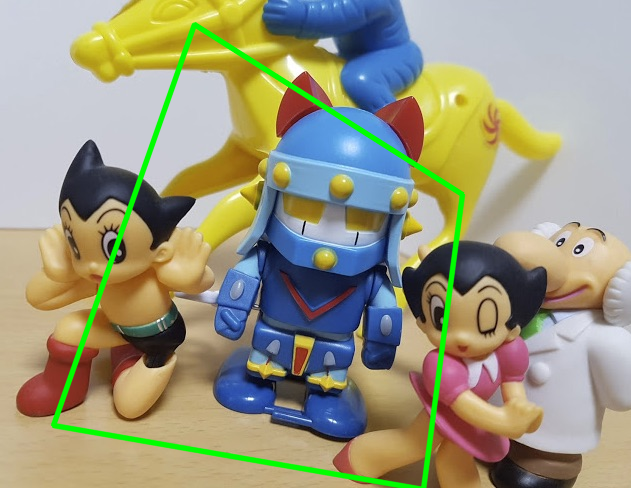

In [6]:
# 매칭점 좌표 추출
import numpy as np
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]) 
    # queryIdx: 첫 번째 이미지의 키포인트 인덱스
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])
    # trainIdx: 두 번째 이미지의 키포인트 인덱스

# RANSAC 알고리즘으로 호모그래피 행렬 계산(임계값 5.0 이하의 점들만 포함)
mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
h,w = img1.shape[:2] # 원본 이미지 크기
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ]) # 원본 이미지의 네 모서리 좌표
dst = cv2.perspectiveTransform(pts, mtrx)  # ..가 img2에 어떻게 변환되는지

# 시각화
img2 = cv2.polylines(img2,[np.int32(dst)],True,(0, 255, 0),3, cv2.LINE_AA)
show(img2)

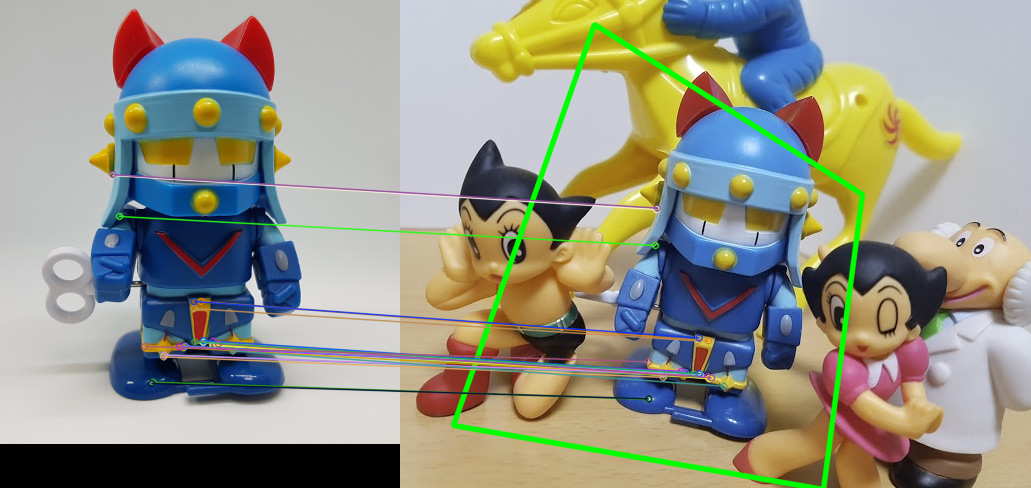

In [7]:
matchesMask = mask.ravel().tolist()  # RANSAC 알고리즘으로 걸러진 좋은 매칭점은 1
[kp for kp, m in zip(matches, matchesMask) if m == 1] # mask 값이 1인 매칭점
res2 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, # ..만 시각화
                       matchesMask = matchesMask,
                       flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
show(res2)

앞 시간 내용을 제가 녹음을 안해서 간단하게 다시 한번 얘기를 드리면 우리가 이제 물체를 탐지를 하는데 우리가 이제 물체가 회전을 하거나 뭐 크기가 달라지거나 이런거를 해도 물체를 탐지를 하기 위해서 일단 키포인트를 추출을 하고요 보통 이제 키포인트를 모서리로 추출하는데 모서리만 추출하면 모서리 위치는 대충 맞지만 모서리 모양이나 이런게 다를 수가 있겠죠

그래서 이제 특징 디스크립터라고 해서 키포인트 주변에 여러가지 주변 정보를 추출을 합니다

그래서 거기서 ORB 특징 검출기 라는 것을 쓰고요 그 다음에 브루트포스 매처 이거는 다 매칭을 해보는 거죠

이것도 매칭해보고 저것도 매칭해보고 다 매칭을 해봐가지고 점수를 매깁니다

그래서 거리를 매겨가지고 이제 비슷하면 거리가 짧겠죠

그리고 좀 차이가 많이 나면 거리가 멀리 나오고 그래서 그런 식으로 이제 정렬을 해서 우리가 매칭 결과를 시각화 해보면 맞게 매칭 되는 것도 있고 좀 이상하게 매칭 되는 것도 있는데 그럼 어쨌든 이중에 그래도 맞게 매칭 되는게 상대적으로 많을 거에요

그래서 그 정보를 이용으로 우리가 호모그래피 변환 행렬이라는 것을 만들어 보면 이거를 어떻게 회전시키고 어떻게 크기를 바꾸고 이렇게 했을 때 우리 템플릿을 이미지에서 어떻게 찾을 수 있느냐

이런 변환을 찾게 되고요

그럼

이렇게 이제 변환을 찾으면 우리가 이제 어느 점이 어느 점에 매칭 되는지를 다시 평가를 해 볼 수가 있겠죠

그래서 이제 좋은 매칭점만 보면은 지금 이제 태권브이 같은 경우에 귀 있는 데랑 서반신 있는 데 부분을 이용을 해서 우리가 이제 매칭이 잘 이루어진다 라는 것을 볼 수 있고 이 좋은 매칭점만 보면은 굉장히 정확하게 매칭을 하고 있는 것을 볼 수 있습니다

이제 이런 식으로 우리가 어떤 물체가 회전을 하거나 지금 다른 물체 사이에 이렇게 있어도 잘 찾아내죠 돌아가 있어도 잘 찾아내고 그 다음에 우리 이제 매칭점으로 볼 때 예를 들면 태권브이 얼굴이 바뀌어도 매칭을 할 수 있다는 것을 알 수 있죠

그래서 태권브이가 얼굴이 바뀌어도 못 알아본다

이런 거고 반대로 말하면 이제 태권브이의 하반신에 있는 어떤 특징들이 많이 사용이 되기 때문에 아마 여기가 이제 뾰족뾰족한 형상이 많아서 그런 것 같아요

그럼 하반신에다가 이제 치마 같은 것을 입혀 놓으면 매칭이 안 되겠죠

그래서 이제 우리가 이런 정보를 활용할 수 있다

이런 거고 그래서 이제 재밌는 것을 하나 보여드리면 우리가 이제 이런 식으로 컴퓨터 비전을 이용해서 물체를 탐지하면 이제 앞에서 봤던 특징점을 이용하는 방법은 뭔가 좀 쉽게 속일 수 있는 것 같은데 그러면 딥러닝 이런 것을 이용하면 해결이 되냐 하면 당연히 딥러닝 이런 것을 이용하면 훨씬 더 탐지를 잘 하긴 하지만 지금 영상을 보시면 여기 이제 person 사람이 탐지가 되고 있는데 굉장히 탐지가 잘 되고 있어요

그런데 이상하게도 여기 턱수염 기르는 사람은 person으로 탐지가 안 되죠

왜 그러냐면 이 사람 배에 붙여 놓은 이 그림 때문에 그렇습니다

이런 것을 어드버서리얼 패치 적대적 패치라고 하는데 왜 적대적이라고 하냐면 이 모델은 이제 어떤 이 사람의 어떤 형상 픽셀들을 가지고 사람으로 구별을 하는 건데 어떤 굉장히 특이한 특징들을 굉장히 많이 가지고 있는 압축적으로 가지고 있는 그림을 이렇게 붙여 놓으면 이제는 인식이 되죠

이걸 뒤집으니까 사람으로 인식이 되는데 굉장히 많은 어떤 색깔들을 잘 섞어 놓으면 사람으로 인식하는 걸 방해를 할 수가 있습니다

이런 걸 어드버서리얼 패치라고 해요

사람으로 인식이 안 되죠

그래서 이제 이 사람만 인식이 안 되는 게 아니라는 걸 보여주고 있는데 그래서 이제 이 사람만 인식이 안 되는 게 아니라는 걸 보여주고 있는데 그래서 이제 이 사람만 인식이 안 되는 게 아니라는 걸 보여주고 있는데 이 패치를 옆 사람한테 넘겨주면 이 패치를 받으니까 이제 이 사람이 인식이 안 됩니다

물론 이제 이 패치가 살짝만 기울어져도 풀리긴 하는데 그러면은 우리가 이제 예를 들면 어디 보안구역을 CCTV로 감시를 하는데 사람이 감시를 안 하고 AI로 감시를 한다

근데 AI가 어떤 AI인지 우리가 그걸 알 수가 있다면 이런 식으로 AI의 약점을 공략하는 적대적 패치를 만들어서 옷에 하나 딱 붙이고 성큼성큼 들어가면은 아무도 없는 줄 알고 그냥 무사 통과를 시켜 줄 수도 있겠죠

그래서 이제 이런 거를 포괄적으로 이제 적대적 공격이라고 하는데 현재 약간 AI 관련돼서 되게 이슈 중에 하나입니다

예를 들면 음성인식 어떤 스피커 음성인식 같은 걸 하는데 우리 군대 같은 데서도 보면은 원래는 어디 이제 진입하려면 그 뭐죠

암구어를 대야 되는데 야

나 중대장이다

이러면은 다 문 열어주듯이 어떤 음성인식을 하는데 그 음성인식을 속일 수 있는 어떤 적대적 멘트 같은 거 적대적인 소리 이런 거를 만들 수가 있다

그러면은 그걸 속일 수가 있는 거죠

예를 들면은 우리가 핸드폰 같은 것들이 다 지금 음성인식으로 여러 가지 기능이 되는데 어떤 핸드폰의 음성인식 기능을 그런 식으로 약점을 공략을 해서 마치 무슨 노래소리처럼 들리지만 그 노래가 AI가 듣기에는 핸드폰을 포맷하고 자폭해라

뭐 약간 이런 식으로 들린다던가 그래서 갑자기 핸드폰이 그 소리 만들면 고장이 난다던가 뭐 그렇게도 만들 수가 있겠죠

그래서 뭐 이런 이슈도 있다

근데 이제 속이기가 이런 거보단 더 어렵겠죠

이거는 이제 딱 보면 바지만 되게 잘 입히면서 속일 수 있지만 이런 적대적 패치 만드는 거는 사실 굉장히 어렵습니다

여기서도 보면 살짝만 움직여도 안 되는 걸 볼 수 있듯이 딥러닝으로 가면은 속이기기는 점점 어려워지긴 해요 모델이 복잡해지니까 그렇지만 어쨌든 속일 방법이 있기는 있다

이런 얘기고 사실 뭐 사람도 우리가 착시현상 이런 게 있어 가지고 사람도 속이려면 속일 수 있잖아요

우리가 보면은 그...

보이스피싱 이런 것도 결국은 이제 사람의 어떤 정신적인 약점을 이용을 해서 속이는 거죠

그래서 이런 이슈도 있다

이 정도로 이제 얘기를 드릴 수 있을 것 같습니다

자 이렇게 해서 네 질문인데요 치마를...

그 특검 부위에 치마를 입히는 게 아니라 그냥 상반신만 가지고 왔을 때는 가는 거라고 인식을 하나요?

상반신만 가져와도 하기는 할 것 같아요

사실 여기 귀에 여기가 특징점으로 사용이 되니까 어 한번 해볼까요?

여기 안에서도 어쨌든 상대적인 거니까 상대적으로 잘 찾을 수도 있습니다

못 찾을 수도 있고 한번 해보죠

돈 드는 거 아니니까요 그리고 코드에서 add 이렇게 바꿔 가지고 해보면 머리를 가지고 여기 약간 맵핑이 좀 잘 되는 거 같긴 한데 머리를 가지고 막 발에도 맵핑하고 지금 난리 났어요

그죠

그래서 해보면은 지금 맵핑이 좀 이상하게 된 걸 볼 수 있죠

우리가 지금 초록색 사각형 보면은 엉뚱한데 맵핑이 좀 되어 있습니다

그리고 막 여기 보면은 지금 엉망진창인데 얼굴만 가지고는 맵핑이 잘 안 된다

이런 거를 볼 수 있고 사람은 얼굴에 굉장히 민감하거든요

사람은 얼굴에 굉장히 민감해서 우리가 어느 정도로 민감하냐면 군중 속에서 화난 사람의 얼굴이 있으면 굉장히 빨리 알아차릴 수 있습니다 실험을 해보면 사람 얼굴 사진을 동시에 0. 몇 초 딱 보여주는 거기 화난 사람 표정의 사람이 하나가 있으면 정말 순간적으로 노출돼도 그 사람 얼굴을 딱 지목할 수 있어요 1 2 3 4 5 6 7 9 칸을 주고 얼굴을 9개를 동시에 0. 몇 초 딱 보여주는데 거기 화난 사람 얼굴 있으면 어 3번 칸이요 어 7번 칸이요 바로 알 수 있습니다 웃는 사람 얼굴은 그렇게 빨리 못 찾아요

그래서 우리가 그 가설 중에 하나가 뇌에 사람 얼굴을 탐지하는 특정한 신경회로가 따로 있는데 그중에서 특히 화난 얼굴을 찾는 회로가 따로 있다.

그래가지고 재밌는 게 뭐냐면 그러면 얼굴이 하나 둘 셋 넷 이렇게 늘어나면 탐지하는 시간이 거기에 비례해서 늘어나야 되잖아요

상식적으로 생각하면 근데 거의 똑같거든요 화난 사람이 4명 중에 한 명이든 3명 중에 한 명이든 2명 중에 한 명이든 탐지하는 시간이 거의 똑같습니다

그 얘기는 하나씩 보고 탐지하는 게 아니라 뭔가 순간적으로 이렇게 딱 나오기만 해도 여기서 보이든 저기서 보이든 우리가 뭘 찾을 때는 어디 있지

이렇게 찾잖아요

근데 화난 사람 얼굴은 그렇게 찾는 게 아니라 뇌에 특수회로가 있어 가지고 그거에 바로 팍 터지게 뭔가

왜냐면 나한테 화난 사람이 있다는 거는 내가 빨리 피하든지 뭔가 대책을 세워야 되잖아요

웃는 사람은 좀 놔둬도 괜찮은데 천천히 반응해도 되는데 화난 사람은 빨리 반응해야겠죠

우리가 이제 약간 생존을 위해서 그런 회로가 있다는 가설이 있어요

어쨌든 사람은 얼굴에 민감한데 특히 화난 얼굴 이거는 지금 얼굴만 보니까 잘 못 찾죠

이런 점을 다시 포인트를 좀 찾아야 될 것 같아요

그렇게는 안 됩니다

왜냐면은 컴퓨터 알고리즘상으로 매칭을 하는 거니까 알고리즘이 찾기 쉬운 점을 얘가 찾는 거거든요

우리가 지정을 해 주면 그 알고리즘으로 매칭하기가 쉽지 않을 수가 있는 거죠

우리가 임의로 하는 방식으로는 안 되고 약간 그 우리가 기계를 쓸 때는 사람을 기계에 맞춰 줘야 됩니다

반대로 해야 되는데 예를 들어 우리가 태권부인데 컴퓨터가 알아보기 쉬운 태권부위를 만들어야겠죠

태권부위를 컴퓨터한테 알아보기 쉽게 하는 게 아니라 약간 반대라고 하실 수 있어요

아니면 딥러닝 같은 거를 사용을 하시면 됩니다